In [3]:
#Importing required packages
import pandas as pd
import numpy as np

#packages for data preparation 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import sklearn

#Xgboost for classification model
import xgboost as xgb

#For train and test split of the data
from sklearn.model_selection import train_test_split

#To evaluate the model performance
from sklearn.metrics import classification_report, confusion_matrix
#To save the model 
import joblib

#For plotting the feature importance from the model
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

#To supress the warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
#To import data from the cloud storage
data=pd.read_csv("gs://aiplatform_demo/Bank_chrun_data/Bank_Churners.csv")


In [17]:
#Data size
print(data.shape)
data

(10127, 21)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [18]:
#Its an imbalanced data set
data['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [30]:
#Attrition_Flag is the target column, removing the target column for X and keeping onlpy the target column for Y
X = data.drop(columns=['Attrition_Flag'])
y = data['Attrition_Flag']

In [31]:
#Splitting the datasets into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100,stratify=y)

In [32]:
#Keeping the column names in separate lists to drop, numerical columns and categorical columns
cols_drop=  ['CLIENTNUM']
cols_numeric = ['Customer_Age', 'Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
cols_categorical = ['Gender','Dependent_count', 'Education_Level', 'Marital_Status','Income_Category','Card_Category']

In [33]:
#Checking for missing values
data.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [34]:
#Scaling of numerical features can be included, since we are using tree based classification model we have not added
#transformer_numeric - pipeline for handling missing values for numerical columns. 
transformer_numeric = Pipeline(steps=[
                                     ('num_mean_imputer', SimpleImputer(strategy='mean')),
                                     ])

#One hot encoding of the categorical columns, we have kept Dependent_count column to be categorical 
transformer_categorical = Pipeline(steps=[
                                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))
                                         ])

In [35]:
#Creating a column transformer to apply the missing value imputation for numerical columns, dropping column which we dont require,
#and also for one hot encoding of the categorical columns. 
transformer_column = ColumnTransformer(transformers=[('drop_columns', 'drop', cols_drop),
                                                   ('numeric_processing',transformer_numeric, cols_numeric),
                                                    ('categorical_processing', transformer_categorical, cols_categorical)
                                                  ], remainder='drop')

In [36]:
#Creating a first pipeline for data transformation. 
pipeline = Pipeline([
                     ('transform_column', transformer_column),
                    ])

In [37]:
#applying fit method to extract the relevant information such as mean, and also other details from the categorical columns, 
pipeline.fit(X_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['CLIENTNUM']),
                                                 ('numeric_processing',
                                                  Pipeline(steps=[('num_mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Customer_Age',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Amt_Chng_Q4_Q1',

In [38]:
#Transforming the X_train dataset first
X_train_transformed=pipeline.transform(X_train)

In [39]:
X_train_transformed.shape
#Number of columns increased from 20 to 40 since we have applied one hot encoding on the categorical columns. 

(8101, 40)

In [ ]:
print(type(X_train_transformed))

In [40]:
pd.DataFrame(X_train_transformed)
#Once we have applied the transformation everything will be in a numpy array, and hence colum names will be not be present.

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,62.0,50.0,6.0,6.0,2802.0,1977.0,825.0,0.431,1757.0,0.833,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,34.0,29.0,4.0,3.0,14938.0,1412.0,13526.0,0.677,1930.0,0.636,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,58.0,47.0,2.0,2.0,2194.0,1302.0,892.0,0.814,4962.0,0.841,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,49.0,37.0,5.0,2.0,3943.0,1135.0,2808.0,0.672,4180.0,0.783,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,41.0,25.0,4.0,2.0,4277.0,2186.0,2091.0,0.804,8764.0,0.683,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,54.0,39.0,4.0,4.0,2702.0,2517.0,185.0,1.019,1658.0,1.462,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8097,47.0,38.0,6.0,3.0,28904.0,1899.0,27005.0,0.850,1334.0,0.400,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8098,39.0,23.0,1.0,3.0,1811.0,0.0,1811.0,0.835,4934.0,0.628,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8099,51.0,36.0,3.0,4.0,1857.0,1033.0,824.0,0.950,5149.0,0.636,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [41]:
#Transforming the X_test dataset
pipeline.transform(X_test)


array([[48., 35.,  3., ...,  0.,  0.,  0.],
       [49., 42.,  5., ...,  0.,  0.,  0.],
       [57., 37.,  3., ...,  0.,  0.,  0.],
       ...,
       [55., 36.,  5., ...,  0.,  0.,  0.],
       [51., 44.,  4., ...,  0.,  0.,  0.],
       [39., 36.,  1., ...,  0.,  0.,  0.]])

In [101]:
#col_categorical=pipeline.named_steps['transform_column'].transformers_[2][1].named_steps['onehotencoding'].get_feature_names(cols_categorical)
col_categorical=pipeline.named_steps['transform_column'].transformers_[2][1].named_steps['onehotencoding'].get_feature_names(cols_categorical)
col_categorical.tolist()

['Gender_F',
 'Gender_M',
 'Dependent_count_0',
 'Dependent_count_1',
 'Dependent_count_2',
 'Dependent_count_3',
 'Dependent_count_4',
 'Dependent_count_5',
 'Education_Level_College',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$120K +',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Blue',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Category_Silver']

In [61]:
new_col_names=cols_numeric+col_categorical.tolist()
new_col_names

['Customer_Age',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Gender_F',
 'Gender_M',
 'Dependent_count_0',
 'Dependent_count_1',
 'Dependent_count_2',
 'Dependent_count_3',
 'Dependent_count_4',
 'Dependent_count_5',
 'Education_Level_College',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Education_Level_Unknown',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Unknown',
 'Income_Category_$120K +',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_Unknown',
 'Card_Category_Blue',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Catego

In [62]:
#To get the column names after the one hot encoding. 
pd.DataFrame(X_train_transformed, columns=new_col_names)

,Customer_Age,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,62.0,50.0,6.0,6.0,2802.0,1977.0,825.0,0.431,1757.0,0.833,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,34.0,29.0,4.0,3.0,14938.0,1412.0,13526.0,0.677,1930.0,0.636,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,58.0,47.0,2.0,2.0,2194.0,1302.0,892.0,0.814,4962.0,0.841,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,49.0,37.0,5.0,2.0,3943.0,1135.0,2808.0,0.672,4180.0,0.783,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,41.0,25.0,4.0,2.0,4277.0,2186.0,2091.0,0.804,8764.0,0.683,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,54.0,39.0,4.0,4.0,2702.0,2517.0,185.0,1.019,1658.0,1.462,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8097,47.0,38.0,6.0,3.0,28904.0,1899.0,27005.0,0.850,1334.0,0.400,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8098,39.0,23.0,1.0,3.0,1811.0,0.0,1811.0,0.835,4934.0,0.628,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8099,51.0,36.0,3.0,4.0,1857.0,1033.0,824.0,0.950,5149.0,0.636,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [64]:
print(y_train.value_counts()[0])
print(y_train.value_counts()[1])
#It is an imbalanced dataset,

6825
1276


In [65]:
imbalance_ratio=y_train.value_counts()[0]/y_train.value_counts()[1]
print(imbalance_ratio)

In [110]:
pipeline_xgb = Pipeline([
                     ('transform_column', transformer_column),
                     ('xgboost', xgb.XGBClassifier(scale_pos_weight=imbalance_ratio))
                    ])

In [111]:
pipeline_xgb.fit(X_train,y_train)

[23:11:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['CLIENTNUM']),
                                                 ('numeric_processing',
                                                  Pipeline(steps=[('num_mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Customer_Age',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Amt_Chng_Q4_Q1',

In [112]:
pipeline_xgb.score(X_test,y_test)

0.9600197433366239

In [113]:
y_predicted = pipeline_xgb.predict(X_test)
print(y_predicted)

In [115]:
confusion_matrix(y_test, y_predicted)

array([[ 282,   69],
       [  12, 1663]], dtype=int64)

In [109]:
print(classification_report(y_test, y_predicted, labels=['Existing Customer','Attrited Customer']))

                   precision    recall  f1-score   support

Existing Customer       0.97      0.99      0.98      1675
Attrited Customer       0.93      0.85      0.89       351

         accuracy                           0.96      2026
        macro avg       0.95      0.92      0.93      2026
     weighted avg       0.96      0.96      0.96      2026



In [78]:
model=pipeline_xgb.named_steps['xgboost']
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.348746081504702,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [116]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

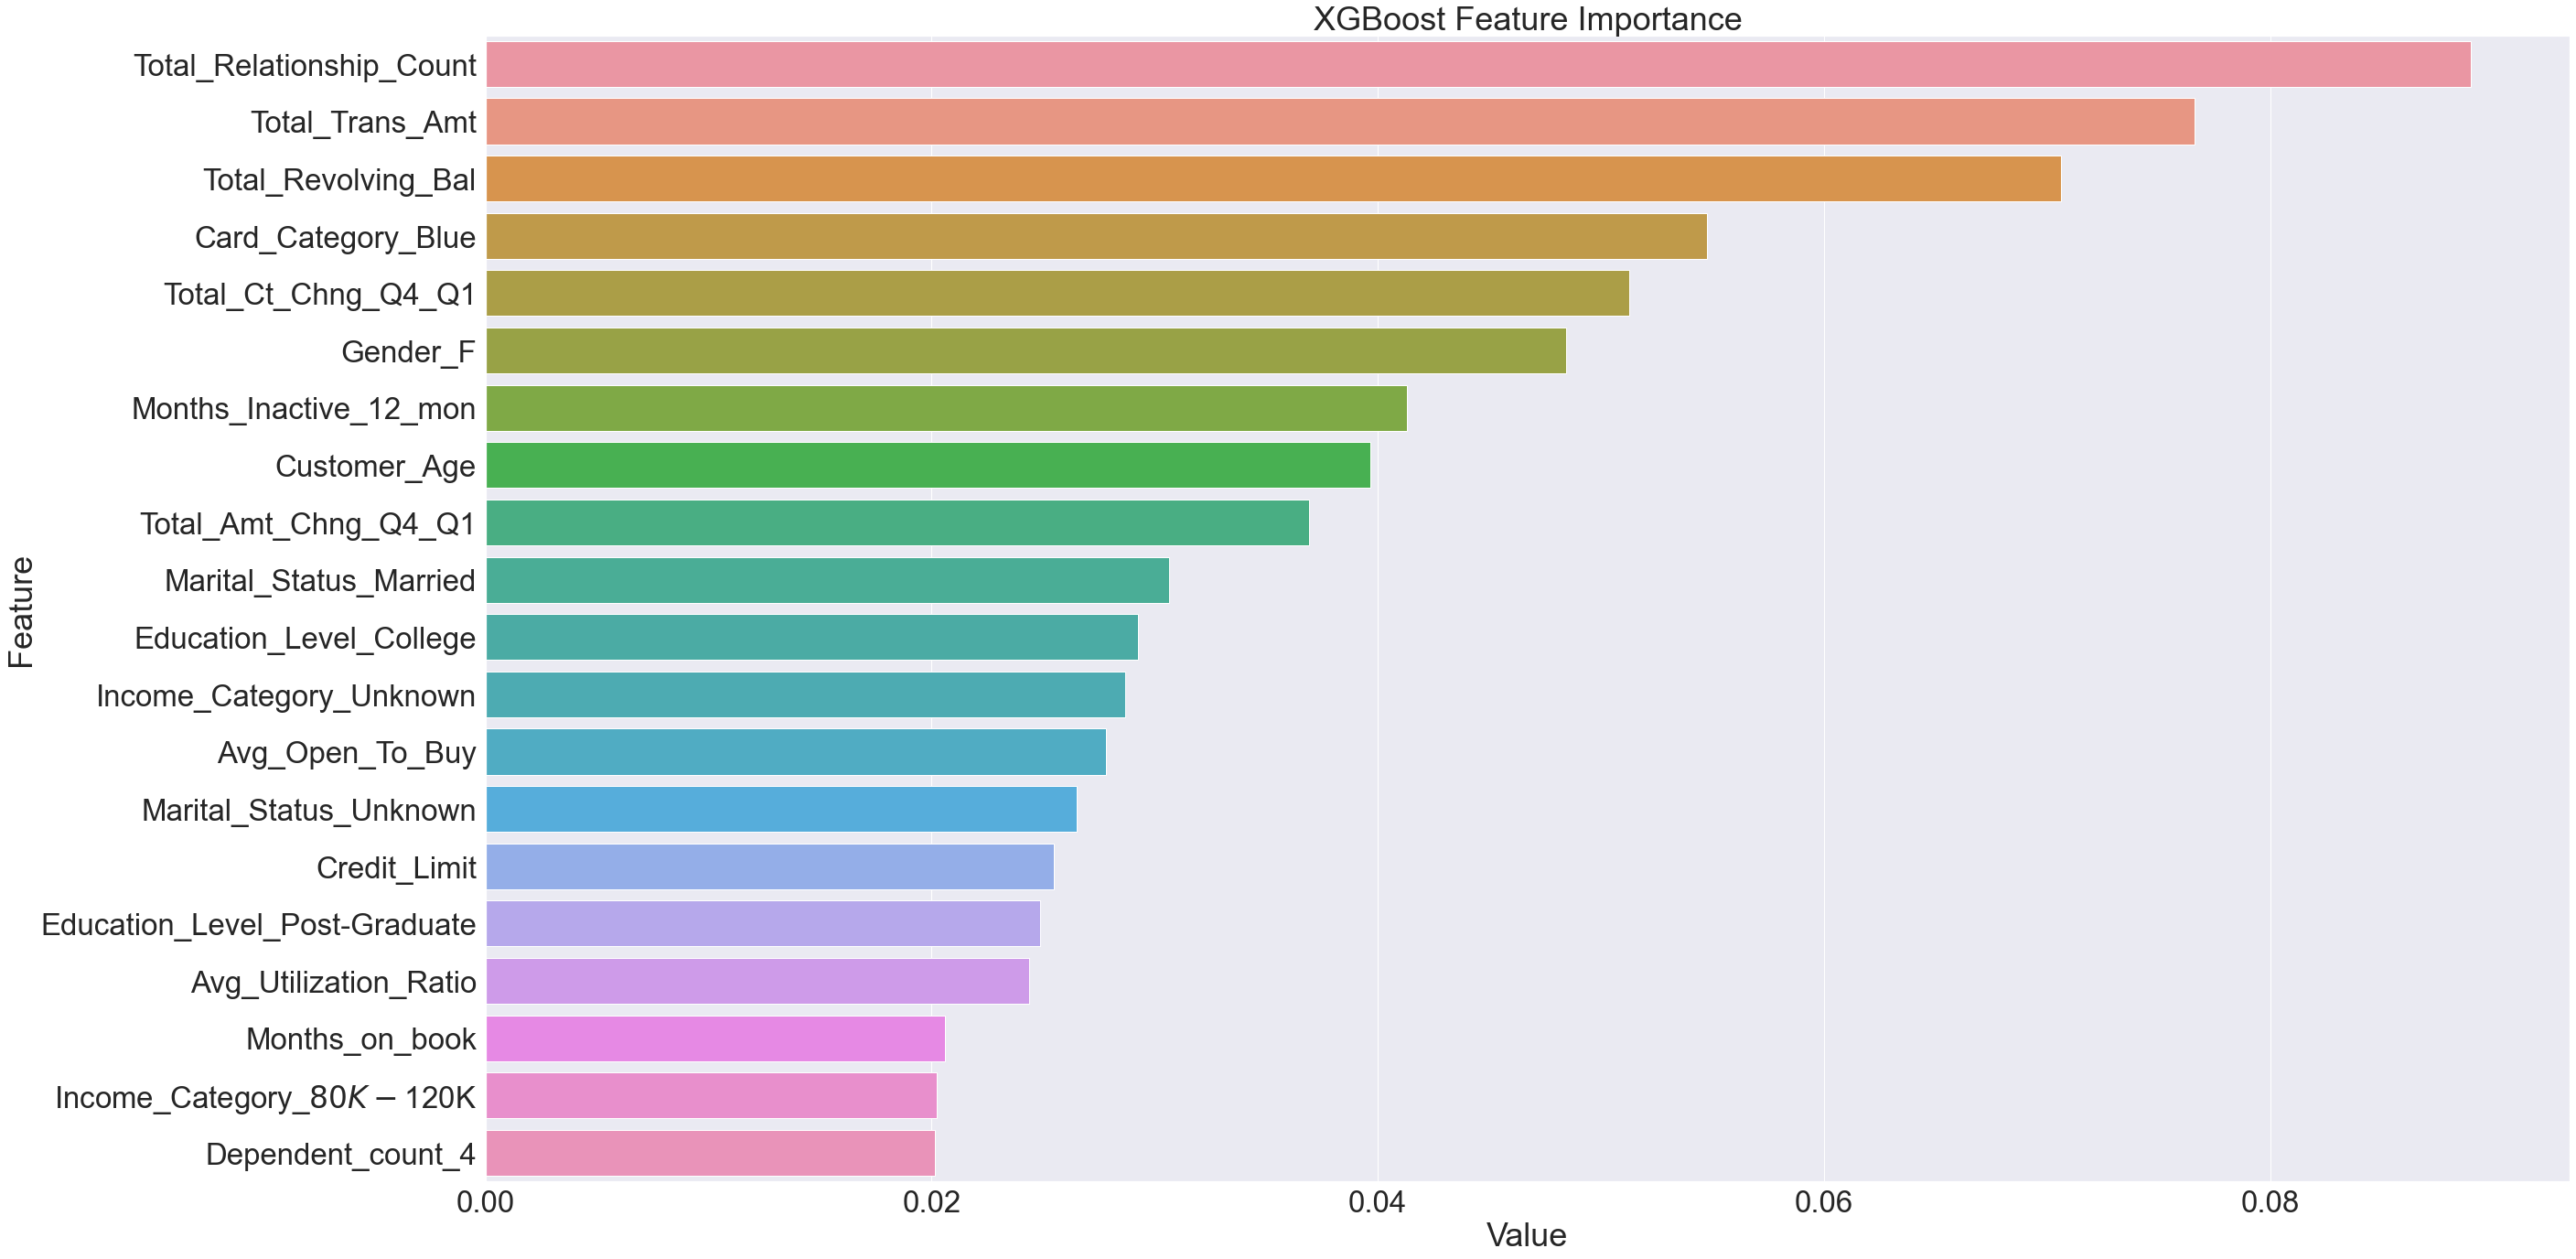

In [117]:
plotImp(model, new_col_names)

In [79]:
joblib.dump(pipeline_xgb, 'model.joblib')

['model.joblib']

In [42]:
job_dir="aiplatform_demo"

In [43]:
REGION="us-west1"

In [44]:
!echo $REGION

us-west1


In [47]:
!gsutil cp ./model.joblib gs://$job_dir/model.joblib

Copying file://./model.joblib [Content-Type=application/octet-stream]...
/ [1 files][391.3 KiB/391.3 KiB]                                                
Operation completed over 1 objects/391.3 KiB.                                    


In [48]:
model = joblib.load("./model.joblib")

In [49]:
instance = ['779031033',46,'F','2','Graduate','Married','$40K - $60K','Blue',22,6,1,3,2305,1627,678,0.747,1230,36,0.565,0.706]
_COLUMN_NAMES=['CLIENTNUM','Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category','Card_Category','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

In [50]:
model.predict(pd.DataFrame(data=[instance], columns=_COLUMN_NAMES))

array(['No'], dtype=object)